# Single CNN Model

In this Jupyter Notebook the single CNN single source model is implemented as a Gurobi optimization problem.

The model aims at placing the layers of a single CNN onto a heterogeneous networks of nodes, minimizing the so-called *decision-making* latency.

Let $N$ be the number of nodes available in the sensor network. Each node $i$, for each $i=1,\ldots,N$, is characterized by constraints on memory $\bar{m}_i$ and computation $\bar{c}_i$, and can carry out $e_i$ operations per second.

Let $M$ be the number of layers of the CNN to be placed. Each layer $j$, for each $j=1,\ldots,M$ has a memory requirement $m_j$ (memory needed to store all the parameters), a number of operations to compute the *output* representation $c_j$, and an output dimensionality $K_j$.

Moreover, let $s$ and $f$ be the source and the sink, i.e., the nodes where the images to be classified by the CNN are gathered and the final classification has to be sent, respectively. In this representation these two particular nodes are assumed to do not carry out any computation, but this constraint can be relaxed by placing nodes on the same position.

The goal of the optimization problem is to minimize the “*data-production to decision-making*“-latency, i.e., the time between when an image is gathered at the source and its classification is delivered to the sink. Given the $N\cdot M$ binary variables $\alpha_{i,j}$s, representing the assignment (or not) of the CNN layer $j$ to the node $i$, the optimization problem is defined as follow:

> $
minimize \sum_{i=1}^{N}\sum_{k=i}^{N}\sum_{j=1}^{M-1} \alpha_{i,j}\cdot\alpha_{k,j+1}\cdot \frac{K_j}{\rho} \cdot d_{i,k} + \sum_{i=1}^{N} t_{i}^{(p)} + t_s + t_f,
$

where

>> $
t_s = \sum_{i=1}^{N} \alpha_{i,1} \cdot \frac{K_s}{\rho} \cdot d_{s,i} 
$

>> $
t_{i}^{(p)} = \sum_{j=1}^{M} \alpha_{i,j} \cdot \frac{c_{j}}{e_i}
$

>> $
t_f = \sum_{i=1}^{N} \alpha_{i,M} \cdot \frac{K_M}{\rho} \cdot d_{i,f} 
$

where the first term represents the transmission latency ($\rho$ represents the data-rate), $t_{i}^{(p)}$ is the processing latency on the node $i$, and $t_s$ and $t_f$ represent the transmission latencies from the source to the first layer and from the last layer to the sink.

The optimization problem is a *binary quadratic optimization problem*, that is NP-complete, and has to be solved with a solver at this time. The constraints of the problem are four.

- All layers are assigned to one node. 

>> $
\forall j \in \mathbb{N}_M \sum_{i=1}^{N} \alpha_{i,j} = 1 
$

- At most $L$ layers are assigned to each node. 

>> $
\forall i \in \mathbb{N}_N \sum_{j=1}^{M} \alpha_{i,j} \le L 
$

- The memory constraint of each node is respected. 

>> $
\forall i \in \mathbb{N}_N \sum_{j=1}^{M} \alpha_{i,j} \cdot m_j \le \bar{m}_i 
$

- The computational constraint of each node is respected.

>> $
\forall i \in \mathbb{N}_N \sum_{j=1}^{M} \alpha_{i,j} \cdot c_j \le \bar{c}_i 
$

## Parameters Definition

The first step of our implementation is the definition of the model parameters.

### Nodes

First of all, the nodes are defined. In this example, up to three technological families of nodes are used, the OrangePi Zero nodes characterized by a memory constraint $\bar{m}=128$ MB and by $e=480\cdot10^6$ operations/s, the BeagleBone AI ($\bar{m}=512$ MB, $e=300\cdot10^6$ operations/s), and the Raspberry Pi 3B+ ($\bar{m}=512$ MB, $e=560\cdot10^6$ operations/s).

All the nodes are located in a squared space of size 2*xm from an uniform distribution. 
By default, the source is drawn from the same distribution and the sink is located in the same position of the source.

In [1]:
import gurobipy as gp
from gurobipy import GRB

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

import graph as gg
import samples

In [2]:
# Parameters
N = 50  # Number of nodes
xm = 5  # Space width as (-xm, +xm)
dt = 3  # Transmission maximum distance
xs = None  # Source x position (None to randomly initialize)
ys = None  # Source y position (None to randomly initialize)
xf = None  # Sink x position (None to randomly initialize)
yf = None  # Sink y position (None to randomly initialize)
sink_is_source = True  # True if Source and Sink are on the same node

orange_p = 0.45  # Percentage of OrangePi Zero
beagle_p = 0.45  # Percentage of BeagleBone AI
pi3_p = 1 - orange_p - beagle_p  # Percentage of Raspberry Pi 3B+

# Max number of layers per node
L = 1
# Datarate (measured in KB/s --> default is 72.2 Mb/s == 9241.6 KB/s)
datarate = 9241.6
# Image Size (measured in KB --> default is a floating-point RGB image of size 227x227)
Ks = 227 * 227 * 3 * 4 / 1024

Define the nodes.

In [3]:
# Create a graph object
graph = gg.create_graph(nodes=N)
# Create the nodes uniformly in the space
xpos, ypos = gg.generate_random_positions(
    nodes=N,
    minx=-xm, maxx=xm,
    miny=-xm, maxy=xm
)

In [4]:
# Create the source
if xs is None:
    xs, xf = np.random.rand(2) * 2 * xm - xm
    ys, yf = np.random.rand(2) * 2 * xm - xm
    if sink_is_source:
        # Fix the sink coordinates
        xf = xs
        yf = ys
        
# Add the source to the graph
graph = gg.add_node_to_graph(graph)
xcoords = np.append(xpos, xs)
ycoords = np.append(ypos, ys)
if not sink_is_source:
    graph = gg.add_node_to_graph(graph)
    xcoords = np.append(xcoords, xf)
    ycoords = np.append(ycoords, yf)

In [5]:
# Create the graph links among reachable nodes.
graph = gg.add_arcs_with_max_distance(
    graph, xcoords, ycoords, dmax=dt
)

# Compute distances
distances = np.zeros((N, N))
for i in range(N):
    for j in range(i, N):
        dij = gg.find_min_distance(graph, i, j)
        distances[i, j] = dij
        distances[j, i] = dij

Once the nodes have been located in the space, they need to be *identified* as one of the known technological units.

In [6]:
# Get configuration
cfg_m, cfg_c, cfg_e = samples.get_node_configuration('orange_beagle_pi3')
# Assign node configuration to each node
sequence = np.random.choice(
    np.arange(len(cfg_m)),
    size=N,
    replace=True,
    p=np.array([orange_p, beagle_p, pi3_p])
)

In [7]:
# Create the data structure for Gurobi
nodes, cbar, mbar, e = gp.multidict({
    i: [cfg_c[s], cfg_m[s], cfg_e[s]]
    for i, s in enumerate(sequence)
})
# Create the distance from the source and to the sink
if sink_is_source:
    nodes, source_dist, dest_dist = gp.multidict({
        i: [gg.find_min_distance(graph, i, N)]*2 
        for i in range(N)
    })
else:
    nodes, source_dist, dest_dist = gp.multidict({
        i: [gg.find_min_distance(graph, i, N),
            gg.find_min_distance(graph, i, N+1)]
        for i in range(N)
    })

Finally, the just created network of sensors is visualized. In particular, the source and sink are represented by an orange star, the STM32H7 nodes by the blue dots, and the Raspberry Pi 3B+ ones by the green diamonds.

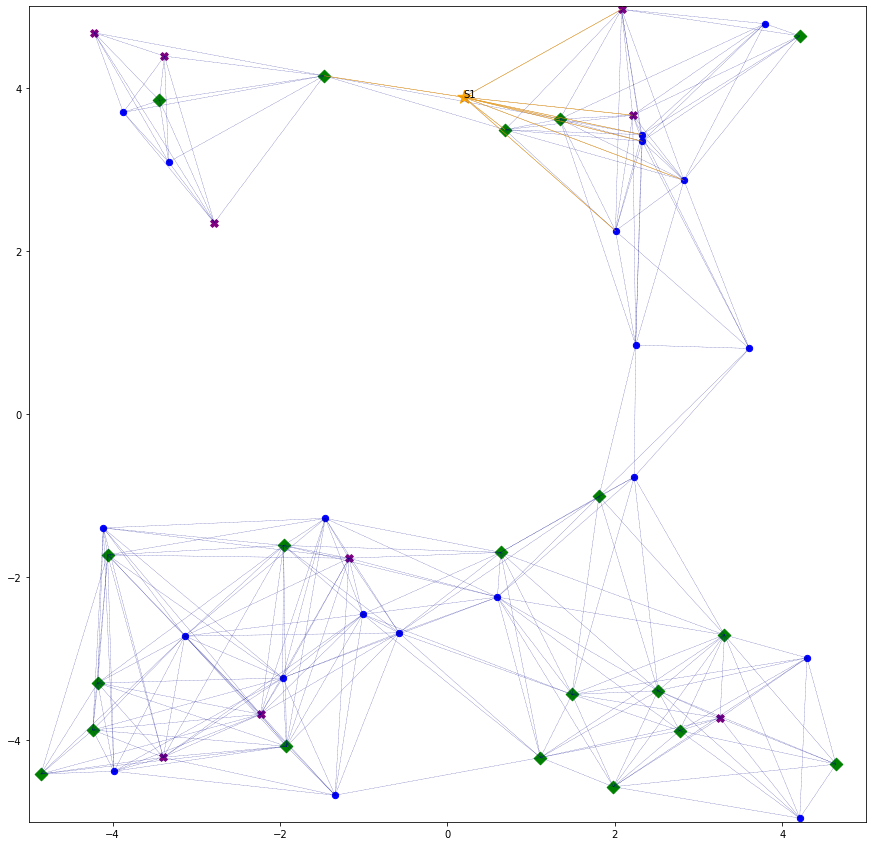

In [9]:
# Plot
gg.plot(
    graph=graph, xpos=xcoords, ypos=ycoords, xm=xm, figsize=(15, 15),
    color=['blue', 'green', 'purple'], marker=['o', 'D', 'X'], size=[40, 80, 60],
    sequence=sequence, num_sources=1
)

### CNN

In this notebook, the CNN is an AlexNet.

In [10]:
# Get connfiguration
cnn_k, cnn_m, cnn_e = samples.get_cnn_configuration('alex')
# Create the data structure for Gurobi
layers, K, m, c = gp.multidict({
    i: [*cnn_params_i]
    for i, cnn_params_i in enumerate(zip(cnn_k, cnn_m, cnn_e))
}
)

## Model Definition

Once all the parameters have been defined, it is time to define the model.

In [ ]:
model = gp.Model('single_cnn_single_source')

Define the binary variables $\alpha_{i,j}$ of shape $N\cdot M$ representing whether the layer $j$ is assigned or not to node $i$. Note that $N$ = *len(nodes)* and $M$ = *len(layers)*.

In [12]:
alpha = model.addVars(len(nodes), len(layers), vtype=GRB.BINARY, name='alpha')

Define the constraints.

In [13]:
# All the layers assigned.
assigned_layer_constraints = \
    model.addConstrs((gp.quicksum(alpha[i, j] for i in nodes) == 1 
                      for j in layers), name='assigned_layer')

# Maximum number of layers per node
layers_per_node_constraints = \
    model.addConstrs((gp.quicksum(alpha[i, j] for j in layers) <= L 
                      for i in nodes), name='layers_per_node')

# Computational Constraints
computational_constraints = \
    model.addConstrs((gp.quicksum(alpha[i, j] * c[j] for j in layers) <= cbar[i]
                      for i in nodes), name='computational_constraints')

# Memory Constraints
memory_constraints = \
    model.addConstrs((gp.quicksum(alpha[i, j] * m[j] for j in layers) <= mbar[i]
                      for i in nodes), name='memory_constraints')

Finally we have to define the objective to be minimized.

The objective to be minimized is the latency from when the data are gathered at the source and the classification is deployed to the sink, so it includes all the processing and transmission latencies.

In [14]:
# Transmission Time + Source Time + Sink Time + Processing Time
model.setObjective(
    gp.quicksum(alpha[i, j] * alpha[k, j+1] * distances[i, k] * K[j] / datarate 
                for i in nodes for k in nodes for j in layers[:-1]) +
    gp.quicksum(alpha[i, 1] * Ks * source_dist[i] / datarate
                for i in nodes) + 
    gp.quicksum(alpha[i, len(layers)-1] * K[len(layers)-1] * dest_dist[i] / datarate
                for i in nodes) + 
    gp.quicksum(alpha[i, j] * c[j] / e[i]
                for i in nodes for j in layers),
    GRB.MINIMIZE
)

Finally, we have to optimize. In this case, we fix the maximum optimization time to 30 seconds.

In [15]:
# Max 30 seconds of optimization
model.setParam(GRB.Param.TimeLimit, 30.0)
# Optimize
model.optimize()

Changed value of parameter TimeLimit to 30.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (mac64)
Optimize a model with 158 rows, 400 columns and 1600 nonzeros
Model fingerprint: 0x31503804
Model has 17150 quadratic objective terms
Variable types: 0 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [8e-03, 3e+00]
  QObjective range [4e-03, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Found heuristic solution: objective 3.8409794
Presolve removed 100 rows and 21 columns
Presolve time: 0.01s
Presolved: 238 rows, 559 columns, 16210 nonzeros
Variable types: 80 continuous, 479 integer (379 binary)
Found heuristic solution: objective 3.5901339

Root relaxation: objective 1.360774e+00, 31 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/

## Visualization of the Optimal Solution.

Once the optimal solution has been found, it is visualized. First of all the optimal latency is printed, thenthe optimal solution *path*, i.e., the sequence of layers as assigned to the network nodes, is visualized, with the same legend of the plot above: the source and sink are represented by an orange star, the STM32H7 nodes by the blue dots, and the Raspberry Pi 3B+ ones by the green diamonds.

In [16]:
# Convert the variables to numpy
alpha_numpy = np.array([alpha[i,j].x for i in nodes for j in layers]).reshape(len(nodes), len(layers))

# Get objective value
latency = model.getObjective().getValue()
print('The latency is {:.3f} seconds'.format(latency))

# Find path
path = np.argwhere(alpha_numpy.T==1)[:,1]

The latency is 1.543 seconds


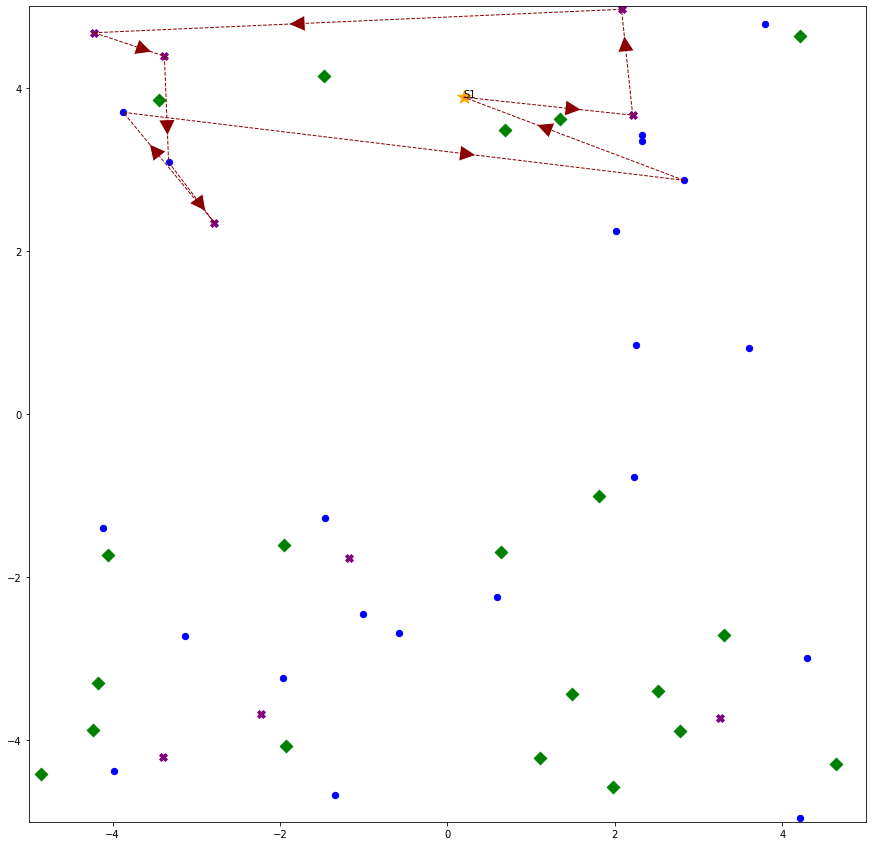

In [17]:
#Plot the path
gg.path_plot(
    path=path, xpos=xcoords, ypos=ycoords, xm=xm, figsize=(15, 15), annotate=False,
    color=['blue', 'green', 'purple'], marker=['o', 'D', 'X'], size=[40, 80, 60],
    sequence=sequence, num_sources=1
)